# imports

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os     
import seaborn as sns 
import cv2  

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten , Input  , Conv2D , MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import save_img



import PIL
from PIL import Image 
import matplotlib.image as mimg 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import gc
import warnings
warnings.filterwarnings("ignore")



# Load data...

In [5]:
folder_path='data'
label_names=os.listdir(folder_path)
print(label_names) 

['without_mask', 'with_mask']


In [6]:
wz_mask=os.path.join(folder_path,'with_mask')
wz_out_mask=os.path.join(folder_path,'without_mask')

In [7]:
with_mask_file=os.listdir(wz_mask)
without_mask_file=os.listdir(wz_out_mask)

In [8]:
print(len(with_mask_file))
print(len(without_mask_file))


3725
3828


In [9]:
WithMaskLabels=[1]*len(with_mask_file)
WithoutMaskLabel=[0]*len(without_mask_file) 

In [10]:
print(len(WithMaskLabels))
print(len(WithoutMaskLabel))

3725
3828


In [11]:
WithMaskLabels[:10],WithoutMaskLabel[-10:]

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
labels=WithMaskLabels+WithoutMaskLabel
print("labels no:",len(labels))
labels[:10],labels[-10:]

labels no: 7553


([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
wz_mask_sample=with_mask_file[150]
wz_out_mask_sample=without_mask_file[200] 

# Plot samples

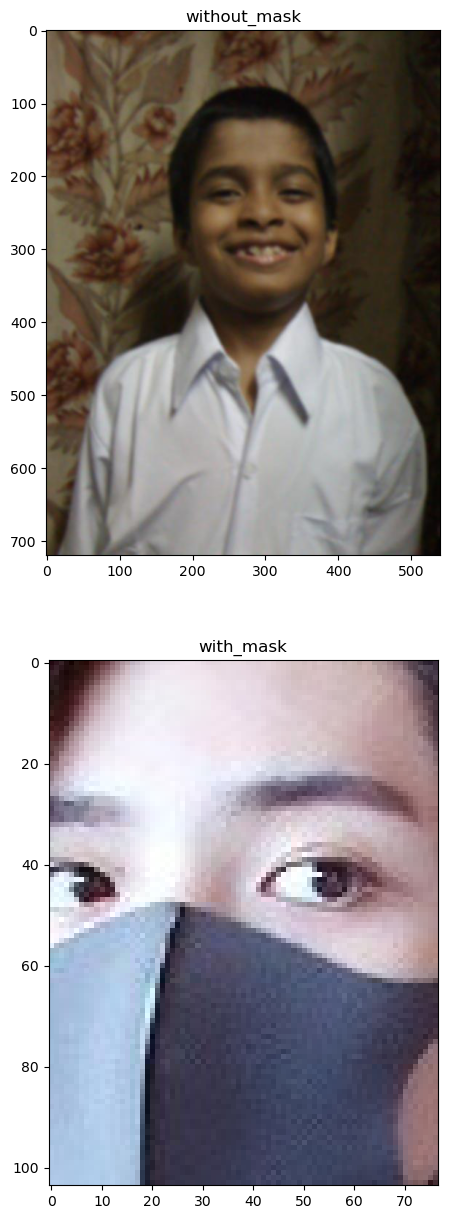

In [14]:
wz_mask_image=os.path.join(wz_mask,wz_mask_sample)
wz_out_mask_image=os.path.join(wz_out_mask,wz_out_mask_sample)


n=[wz_out_mask_image,wz_mask_image]
plt.figure(figsize=(15,15))
for i in range(2):

    plt.subplot(2,1,i+1)
    plt.title(label_names[i])
    img=plt.imread(n[i])
    plt.imshow(img)



In [15]:
type(img)

numpy.ndarray

In [16]:
img.shape

(104, 77, 3)

# Labeling the data

In [17]:
type(labels)

list

In [18]:
with_mask_path = 'data/with_mask'

images = []

for img_file in with_mask_file:

    file_path = os.path.join(with_mask_path, img_file)

    img = Image.open(file_path)

    img = img.resize((128,128))

    img = img.convert('RGB')

    img = np.array(img)

    images.append(img)

    gc.collect() 

In [19]:
without_mask_path = 'data/without_mask'

for img_file in without_mask_file:

    file_path = os.path.join(without_mask_path, img_file)
    
    img = Image.open(file_path)

    img = img.resize((128,128))

    img = img.convert('RGB')

    img = np.array(img)

    images.append(img)

    gc.collect() 

In [20]:
type(images)

list

In [21]:
images[0].shape

(128, 128, 3)

In [22]:
len(images)

7553

In [23]:
x=np.array(images)
y=np.array(labels)

In [24]:
type(x),type(y)

(numpy.ndarray, numpy.ndarray)

In [25]:
print(x.shape,y.shape)

(7553, 128, 128, 3) (7553,)


# splite data

In [26]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42) 

In [27]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6042, 128, 128, 3) (6042,)
(1511, 128, 128, 3) (1511,)


In [28]:
x_train[0] , y_train


(array([[[ 40,  17,  13],
         [ 42,  18,  14],
         [ 46,  20,  16],
         ...,
         [ 45,  29,  30],
         [ 44,  29,  32],
         [ 44,  29,  32]],
 
        [[ 44,  18,  15],
         [ 47,  21,  17],
         [ 54,  25,  21],
         ...,
         [ 45,  30,  31],
         [ 44,  29,  32],
         [ 44,  29,  32]],
 
        [[ 53,  23,  18],
         [ 58,  27,  22],
         [ 69,  36,  30],
         ...,
         [ 44,  29,  30],
         [ 43,  28,  31],
         [ 43,  28,  31]],
 
        ...,
 
        [[138, 186, 165],
         [135, 186, 164],
         [127, 182, 161],
         ...,
         [177, 120, 111],
         [179, 122, 112],
         [181, 123, 114]],
 
        [[153, 189, 171],
         [150, 189, 170],
         [145, 188, 168],
         ...,
         [176, 119, 108],
         [178, 121, 109],
         [178, 121, 110]],
 
        [[158, 196, 177],
         [155, 196, 178],
         [151, 196, 176],
         ...,
         [174, 117, 106],
  

In [29]:
x_train.shape ,y_train.shape,

((6042, 128, 128, 3), (6042,))

# Build generator

In [30]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(x_train, y_train, batch_size=32)

test_generator = datagen.flow(x_test, y_test, batch_size=32)

# Build model stracture

In [31]:
Nn_model=Sequential()
input_shape=(128,128,3)

Nn_model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
Nn_model.add(MaxPooling2D((2,2)))

Nn_model.add(Conv2D(64,(3,3),activation='relu'))
Nn_model.add(MaxPooling2D((2,2)))

Nn_model.add(Conv2D(64,(3,3),activation='relu'))
Nn_model.add(MaxPooling2D((2,2)))

Nn_model.add(GlobalAveragePooling2D())  
Nn_model.add(Dropout(0.5))

Nn_model.add(Dense(512,activation='relu'))

Nn_model.add(Dense(256,activation='relu'))
Nn_model.add(Dropout(0.5))

Nn_model.add(Dense(256,activation='relu'))

Nn_model.add(Dense(128,activation='relu'))
Nn_model.add(Dropout(0.5))

Nn_model.add(Dense(128,activation='relu'))

Nn_model.add(Dense(64,activation='relu'))
Nn_model.add(Dropout(0.5))

Nn_model.add(Dense(32,activation='relu'))

Nn_model.add(Dense(16,activation='relu'))
Nn_model.add(Dropout(0.5))


Nn_model.add(Dense(1,activation='sigmoid',kernel_regularizer=l2(0.001)))


# Compile the model

In [32]:
Nn_model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=[
                  "accuracy"
                    ])
Nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

# Train model

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
History = Nn_model.fit(train_generator, epochs=20, batch_size=16, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/20
189/189 [==============================] - 502s 3s/step - loss: 0.6858 - accuracy: 0.5631 - val_loss: 0.6347 - val_accuracy: 0.7512
Epoch 2/20
189/189 [==============================] - 313s 2s/step - loss: 0.6698 - accuracy: 0.6079 - val_loss: 0.6000 - val_accuracy: 0.7406
Epoch 3/20
189/189 [==============================] - 198s 1s/step - loss: 0.6220 - accuracy: 0.7016 - val_loss: 0.5823 - val_accuracy: 0.7445
Epoch 4/20
189/189 [==============================] - 219s 1s/step - loss: 0.5958 - accuracy: 0.7205 - val_loss: 0.5578 - val_accuracy: 0.7584
Epoch 5/20
189/189 [==============================] - 199s 1s/step - loss: 0.5686 - accuracy: 0.7436 - val_loss: 0.5022 - val_accuracy: 0.7975
Epoch 6/20
189/189 [==============================] - 200s 1s/step - loss: 0.5336 - accuracy: 0.7628 - val_loss: 0.4630 - val_accuracy: 0.8147
Epoch 7/20
189/189 [==============================] - 207s 1s/step - loss: 0.4955 - accuracy: 0.7956 - val_loss: 0.3599 - val_accuracy: 0.8782

# save and valid the model

In [34]:
# In your notebook, after training:
Nn_model.save('face_mask_finally2.keras', save_format='keras_v3')

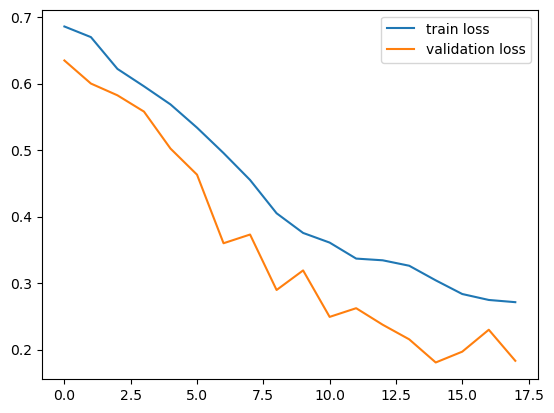

In [35]:
history = History

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

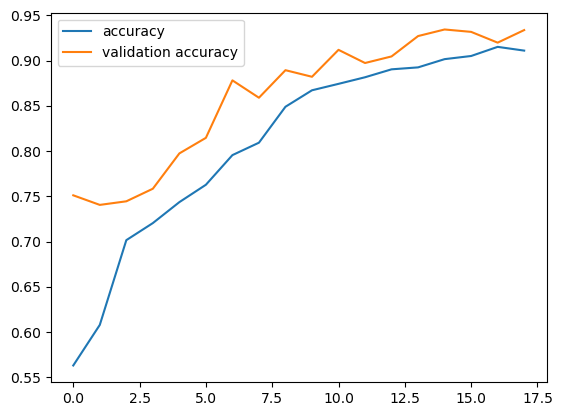

In [36]:
plt.plot(History.history['accuracy'], label='accuracy')
plt.plot(History.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()